In [ ]:
from transformers import YolosFeatureExtractor, YolosForObjectDetection
from PIL import Image
import requests

url = '{INPUT_PLAT}'
image = Image.open(requests.get(url, stream=True).raw)
feature_extractor = YolosFeatureExtractor.from_pretrained('nickmuchi/yolos-small-finetuned-license-plate-detection')
model = YolosForObjectDetection.from_pretrained('nickmuchi/yolos-small-finetuned-license-plate-detection')
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

# model predicts bounding boxes and corresponding face mask detection classes
logits = outputs.logits
bboxes = outputs.pred_boxes


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/yolos/feature_extraction_yolos.py:40: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json:   0%|          | 0.00/907 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/123M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/123M [00:00<?, ?B/s]

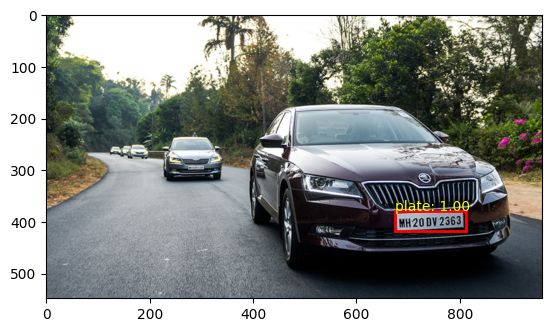

In [ ]:
import torch
import matplotlib.pyplot as plt

logits = outputs.logits
boxes = outputs.pred_boxes

# Softmax ke probabilitas
probs = logits.softmax(-1)[0]

# Buat figure
plt.imshow(image)

# Loop hasil deteksi
for prob, box in zip(probs, boxes[0]):
    score, label = prob.max(-1)
    if label.item() == 1 and score > 0.7:  # 1 = license plate
        cx, cy, w, h = box.tolist()
        img_w, img_h = image.size
        x1 = (cx - w/2) * img_w
        y1 = (cy - h/2) * img_h
        x2 = (cx + w/2) * img_w
        y2 = (cy + h/2) * img_h
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                             fill=False, color="red", linewidth=2)
        plt.gca().add_patch(rect)
        plt.text(x1, y1, f"plate: {score:.2f}", color="yellow")

plt.show()


In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

# ambil logits (kelas) & boxes dari output YOLOS
logits = outputs.logits
boxes = outputs.pred_boxes

# hitung probabilitas
probs = logits.softmax(-1)[0]  # shape: [num_queries, num_classes]
boxes = boxes[0]               # shape: [num_queries, 4]

img_w, img_h = image.size
threshold = 0.7  # confidence minimal

roi_counter = 0
for prob, box in zip(probs, boxes):
    score, label = prob.max(-1)
    if label.item() == 1 and score > threshold:  # label=1 → license plate
        cx, cy, w, h = box.tolist()

        # konversi dari format relatif (cx, cy, w, h) → pixel koordinat
        x1 = int((cx - w/2) * img_w)
        y1 = int((cy - h/2) * img_h)
        x2 = int((cx + w/2) * img_w)
        y2 = int((cy + h/2) * img_h)

        # crop ROI dari gambar asli
        roi = image.crop((x1, y1, x2, y2))

        # simpan sebagai PNG
        output_path = f"plate_{roi_counter}.jpg"
        roi.save(output_path)
        print(f"✅ ROI plat nomor disimpan: {output_path}")
        roi_counter += 1


✅ ROI plat nomor disimpan: plate_0.jpg


In [ ]:
from transformers import YolosFeatureExtractor, YolosForObjectDetection
from PIL import Image
import requests
import torch

# === STEP 1: Load YOLOS untuk deteksi plat nomor ===
image_path = "/content/plat.webp"
image = Image.open(image_path).convert("RGB")

feature_extractor = YolosFeatureExtractor.from_pretrained(
    'nickmuchi/yolos-small-finetuned-license-plate-detection'
)
det_model = YolosForObjectDetection.from_pretrained(
    'nickmuchi/yolos-small-finetuned-license-plate-detection'
)

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = det_model(**inputs)

# Ambil hasil prediksi
logits = outputs.logits
bboxes = outputs.pred_boxes  # [batch, num_queries, 4]

# === STEP 2: Ambil box dengan skor tertinggi ===
probabilities = logits.softmax(-1)[0, :, :-1]  # remove no-object class
scores, labels = probabilities.max(-1)
best_idx = torch.argmax(scores)

box = bboxes[0, best_idx].detach().cpu().numpy()  # format: cx, cy, w, h (relative 0-1)

# Konversi ke koordinat piksel
width, height = image.size
cx, cy, w, h = box
xmin = int((cx - w/2) * width)
ymin = int((cy - h/2) * height)
xmax = int((cx + w/2) * width)
ymax = int((cy + h/2) * height)

# Crop ROI (plat nomor)
plate_img = image.crop((xmin, ymin, xmax, ymax))
plate_img.save("plate.png")  # Simpan hasil crop sebagai PNG
print("Plat nomor berhasil diekstrak ke plate.png")


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Plat nomor berhasil diekstrak ke plate.png


In [ ]:
from transformers import YolosFeatureExtractor, YolosForObjectDetection
from PIL import Image
import torch

# === STEP 1: Load YOLOS untuk deteksi plat nomor ===
image_path = "/content/pentil.png"
image = Image.open(image_path).convert("RGB")

feature_extractor = YolosFeatureExtractor.from_pretrained(
    'nickmuchi/yolos-small-finetuned-license-plate-detection'
)
det_model = YolosForObjectDetection.from_pretrained(
    'nickmuchi/yolos-small-finetuned-license-plate-detection'
)

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = det_model(**inputs)

# Ambil hasil prediksi
logits = outputs.logits
bboxes = outputs.pred_boxes  # [batch, num_queries, 4]

# === STEP 2: Ambil semua box dengan skor > threshold ===
probabilities = logits.softmax(-1)[0, :, :-1]  # remove no-object class
scores, labels = probabilities.max(-1)

threshold = 0.7  # bisa disesuaikan
selected_indices = torch.where(scores > threshold)[0]

width, height = image.size

for idx, box_idx in enumerate(selected_indices):
    box = bboxes[0, box_idx].detach().cpu().numpy()  # format: cx, cy, w, h
    cx, cy, w, h = box

    xmin = int((cx - w/2) * width)
    ymin = int((cy - h/2) * height)
    xmax = int((cx + w/2) * width)
    ymax = int((cy + h/2) * height)

    # Crop ROI plat nomor
    plate_img = image.crop((xmin, ymin, xmax, ymax))
    filename = f"plate_{idx}.png"
    plate_img.save(filename)
    print(f"Plat nomor {idx} berhasil diekstrak ke {filename}")


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Plat nomor 0 berhasil diekstrak ke plate_0.png
Plat nomor 1 berhasil diekstrak ke plate_1.png


In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image

# === STEP 3: OCR dengan TrOCR ===
plate_img = Image.open("2.jpg").convert("RGB")

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
ocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

pixel_values = processor(plate_img, return_tensors="pt").pixel_values
generated_ids = ocr_model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Hasil OCR Plat Nomor:", generated_text)


FileNotFoundError: [Errno 2] No such file or directory: '2.jpg'

In [ ]:
# Install YOLOS dependencies
!pip install transformers torch torchvision

# Install fast-plate-ocr dengan GPU support
!pip install fast-plate-ocr[onnx-gpu]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.8 MB/s eta 0:00:00


In [ ]:
from fast_plate_ocr import LicensePlateRecognizer

# Load model OCR yang ringan & cepat
ocr_model = LicensePlateRecognizer("cct-xs-v1-global-model")

# Jalankan OCR pada hasil crop YOLOS
result = ocr_model.run("5.jpg")
print("🔎 Hasil OCR Plat Nomor:", result)


*************** EP Error ***************
EP Error /onnxruntime_src/onnxruntime/python/onnxruntime_pybind_state.cc:505 void onnxruntime::python::RegisterTensorRTPluginsAsCustomOps(PySessionOptions&, const onnxruntime::ProviderOptions&) Please install TensorRT libraries as mentioned in the GPU requirements page, make sure they're in the PATH or LD_LIBRARY_PATH, and that your GPU is supported.
 when using ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.
****************************************
🔎 Hasil OCR Plat Nomor: ['7118DD___']


In [ ]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 21.9 MB/s eta 0:00:00


In [ ]:
import easyocr
reader = easyocr.Reader(['id','en']) # this needs to run only once to load the model into memory
reader.readtext('/content/5.jpg', detail = 0)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


['B   2833 XKX']

In [ ]:
import requests
from PIL import Image
import torch

from transformers import OwlViTProcessor, OwlViTForObjectDetection

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
text_labels = [["a photo of a cat", "a photo of a dog"]]
inputs = processor(text=text_labels, images=image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.tensor([(image.height, image.width)])
# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = processor.post_process_grounded_object_detection(
    outputs=outputs, target_sizes=target_sizes, threshold=0.1, text_labels=text_labels
)
# Retrieve predictions for the first image for the corresponding text queries
result = results[0]
boxes, scores, text_labels = result["boxes"], result["scores"], result["text_labels"]
for box, score, text_label in zip(boxes, scores, text_labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text_label} with confidence {round(score.item(), 3)} at location {box}")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Detected a photo of a cat with confidence 0.707 at location [324.97, 20.44, 640.58, 373.29]
Detected a photo of a cat with confidence 0.717 at location [1.46, 55.26, 315.55, 472.17]


In [ ]:
# Cell 1 — cek GPU
!nvidia-smi


Mon Sep 22 16:34:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -U onnxruntime-gpu
# (opsional) reinstall fast-alpr jika butuh:
!pip install -U fast-alpr[onnx-gpu]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.9 MB/s eta 0:00:00


In [ ]:
import os
os.environ['ORT_TENSORRT_DISABLE'] = '1'   # non-aktifkan percobaan TensorRT

# sekarang cek provider yang tersedia
import onnxruntime as ort
print("onnxruntime version:", ort.__version__)
print("available providers:", ort.get_available_providers())

onnxruntime version: 1.22.0
available providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [ ]:
!pip install fast-alpr[onnx-gpu]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
# Cell 4 — kode ALPR (contoh)
from fast_alpr import ALPR

alpr = ALPR(
    detector_model="yolo-v9-t-384-license-plate-end2end",
    ocr_model="cct-xs-v1-global-model",
)

# pakai file lokal di /content
results = alpr.predict("/content/pentil.png")
print(results)


INFO:open_image_models.detection.core.yolo_v9.inference:Using ONNX Runtime with ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider'] provider(s)
INFO:open_image_models.detection.pipeline.license_plate:Initialized LicensePlateDetector with model /root/.cache/open-image-models/yolo-v9-t-384-license-plate-end2end/yolo-v9-t-384-license-plates-end2end.onnx


*************** EP Error ***************
EP Error /onnxruntime_src/onnxruntime/python/onnxruntime_pybind_state.cc:505 void onnxruntime::python::RegisterTensorRTPluginsAsCustomOps(PySessionOptions&, const onnxruntime::ProviderOptions&) Please install TensorRT libraries as mentioned in the GPU requirements page, make sure they're in the PATH or LD_LIBRARY_PATH, and that your GPU is supported.
 when using ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.
****************************************
*************** EP Error ***************
EP Error /onnxruntime_src/onnxruntime/python/onnxruntime_pybind_state.cc:505 void onnxruntime::python::RegisterTensorRTPluginsAsCustomOps(PySessionOptions&, const onnxruntime::ProviderOptions&) Please install TensorRT libraries as mentioned in the GPU requirements page, make sure they're in the PATH or LD_LIBRARY_PATH, and that your GPU is supported.
 when using ['TensorrtExe